# Deep Residual Learning For Image Recognition



This passage will lead you through the whole process of the implementation of image classification tasks on CIFAR-10 and also explain some confusing parts for beginners in detail. Besides, I also put down what I've learned in the middle and hope you will at least grasp how you should build up the whole pipeline of conv net at last.

In [66]:
#notebook setup
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.datasets as dset
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR


import numpy as np
from utils import progress_bar

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


And also some useful function:

In [2]:
def show_images(imgs):
    NUM = imgs.shape[0]
    
    sqrtn = int(np.ceil(np.sqrt(NUM)))
    sqrtimg = int(np.ceil(np.sqrt(NUM)))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(imgs):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img)
    return

## Classification tasks on CIFAR-10

First we need to download the data if needed. And then preprocess as following:

1. 4 pixels padding and random cropping
2. flipping randomly
3. normalize

***

The intuition behind them are explained [here](https://stackoverflow.com/questions/32842308/random-cropping-and-flipping-in-convolutional-neural-networks/32844299):

>This is referred to as **data augmentation**. By applying transformations to the training data, you're adding synthetic data points. This exposes the model to additional variations without the cost of collecting and annotating more data. This can have the effect of reducing overfitting and improving the model's ability to generalize.

>The intuition behind **flipping** an image is that an object should be equally recognizable as its mirror image. Note that horizontal flipping is the type of flipping often used. Vertical flipping doesn't always make sense but this depends on the data.

>The idea behind **cropping** is that to reduce the contribution of the background in the CNNs decision. That's useful if you have labels for locating where your object is. This lets you use surrounding regions as negative examples and building a better detector. Random cropping can also act as a regularizer and base your classification on the presence of parts of the object *instead of focusing everything on a very distinct feature* that may not always be present.

And a very approaching idea on random cropping:

>I think random cropping also associate a broader range of spatial activation statistics with a certain class label and thus makes the algorithm more robust.

***

Some tips here:
1. just mentioned CIFAR in PyTorch will load all data into memory at the beginning, not to large.
2. T.ToTensor will convert img in the range [0,255] to that in [0,1]. Some codes Normalize them using (0.5,0.5,0.5) to rescale it to range(-1,1) after ToTensor operation.

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


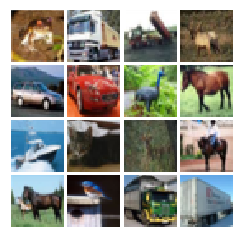

In [3]:
# size of the image dataset N * 32 * 32 * 3
NUM_TRAIN = 45000
NUM_VAL = 5000


train_CIFAR = dset.CIFAR10('../datasets/', train=True, download=True)
train_mean = np.mean(train_CIFAR.train_data, axis=(0,1,2))/255
train_std = np.std(train_CIFAR.train_data, axis=(0,1,2))/255

train_transform = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(train_mean, train_std)
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(train_mean, train_std)
])
train_CIFAR = dset.CIFAR10('../datasets/', train=True, download=True, transform = train_transform)
train_loader = DataLoader(train_CIFAR, batch_size = 128, num_workers=2, 
                          sampler= SubsetRandomSampler(list(range(NUM_TRAIN))))
val_loader = DataLoader(train_CIFAR, batch_size = 128, num_workers=2, 
                          sampler= SubsetRandomSampler(list(range(NUM_TRAIN,(NUM_TRAIN+NUM_VAL)))))

test_CIFAR = dset.CIFAR10('../datasets/', train=False, download=True, transform= test_transform)
test_loader = DataLoader(test_CIFAR, batch_size = 128, num_workers=2, shuffle=False)

NUM_SHOW = 16

img =train_CIFAR.train_data[:NUM_SHOW,:]
show_images(img)

Then we will import Resnet-18, 50 to train our dataset on the training data. These two models use different architecture, one with basic block and the other with one called bottleneck. I specifically choose these two different sorts of models with relatively less layers due to the limit of the computational resources.

Some points need to pay attention to:
1. I update the learning rate by a decreasing factor of 0.1 at epoch 100 and 150
2. 

In [6]:
from resnet import Resnet18


net = Resnet18()

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=8e-4, nesterov= True)
scheduler = MultiStepLR(optimizer, [100,150], gamma=0.1)

In [7]:
use_cuda = torch.cuda.is_available()
#msg = 
print('GPU %s available on this machine!' %('is' if use_cuda else 'is not' ))
if use_cuda:
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

def train(epoch):
    global train_data
    loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    test_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    train_data['test_acc_hist'] =  test_acc_hist
    
    
    for i in range(epoch):
        print('This is epoch:{}'.format(i+1))
        total= 0
        correct=0
        scheduler.step()
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss.data[0], 100.*correct/total, correct, total))
            if j % 50==0:
                loss_hist.append(loss.data[0])
            
        train_acc_hist.append(100.*correct/total)
        if i %1 == 0:
            acc = test(val_loader)
            val_acc_hist.append(acc)
            print('Epoch {}, loss: {}, accuracy: {}'.format(i+1, loss_hist[-1], acc))
            acc = test(test_loader)
            test_acc_hist.append(acc)
            print('Epoch {}, loss: {}, accuracy: {}'.format(i+1, loss_hist[-1], acc))
                
def test(val_load):
    net.eval()
    total = 0
    positive = 0
    for val_x, val_y in val_load:
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        #print(out.size())
        positive += (torch.max(out,1)[1]==y).sum().data[0]
        total += out.size()[0]
    acc =  (positive*100.0)/total
    return acc     

train(200)

GPU is available on this machine!
This is epoch:1
 [============================================>] 352/352   Step: 143ms | Tot: 1m17s | Loss: 1.298 | Acc: 38.960% (17532/45000)4))
Epoch 1, loss: 1.1875641345977783, accuracy: 44.88
Epoch 1, loss: 1.1875641345977783, accuracy: 45.34
This is epoch:2
 [============================================>] 352/352   Step: 145ms | Tot: 1m17s | Loss: 0.727 | Acc: 57.956% (26080/45000)4))
Epoch 2, loss: 0.9993833303451538, accuracy: 53.66
Epoch 2, loss: 0.9993833303451538, accuracy: 53.23
This is epoch:3
 [============================================>] 352/352   Step: 146ms | Tot: 1m16s | Loss: 0.876 | Acc: 68.071% (30632/45000)4))
Epoch 3, loss: 0.7159119248390198, accuracy: 58.98
Epoch 3, loss: 0.7159119248390198, accuracy: 59.03
This is epoch:4
 [============================================>] 352/352   Step: 146ms | Tot: 1m16s | Loss: 0.691 | Acc: 73.153% (32919/45000)4))
Epoch 4, loss: 0.6562046408653259, accuracy: 66.86
Epoch 4, loss: 0.65620464

I use total 200 epoches. Thanks to the GPU, the training time for each epoch is merely 1.25 minutes, which is a drastically cut compared to almost 50 minutes via CPU. Then, I will try to visualise the whole training process and see what happens in the process.

In [9]:
import pickle

with open('resnet18data.pkl','wb') as f:
    pickle.dump(train_data,f)
with open('resnet18data.pkl', 'rb') as f:
    train_data = pickle.load(f)

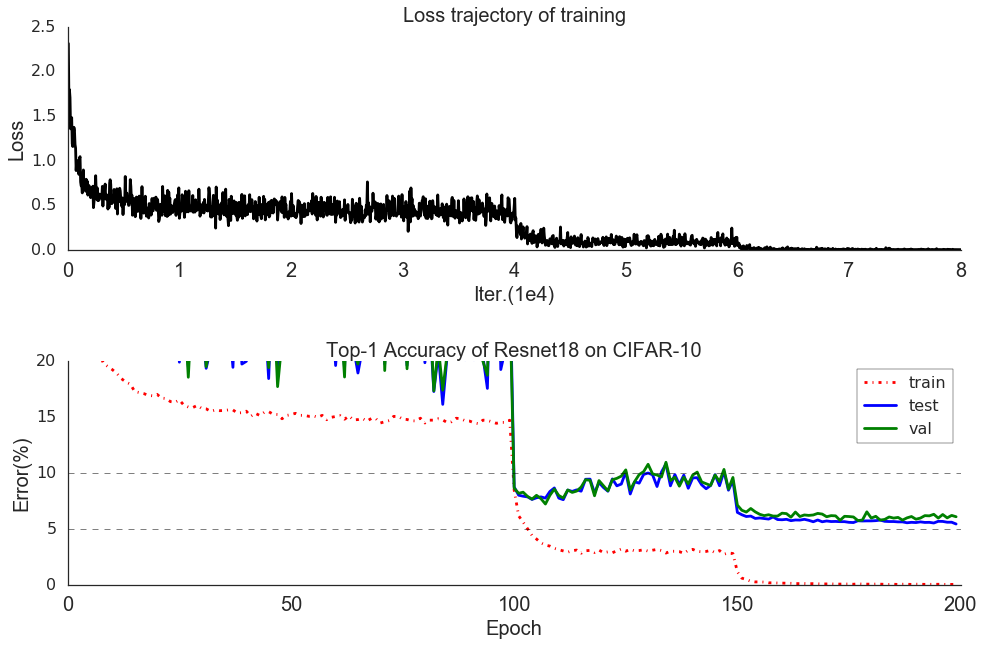

In [107]:
plt.style.use('seaborn-white')
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels

gs = gridspec.GridSpec(2,1)
gs.update(hspace=0.5)
fig = plt.figure(figsize=(16,10))
fig1 = fig.add_subplot(gs[0,0])
fig2 = fig.add_subplot(gs[1,0])
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
# for item in [fig1.xaxis.label, fig1.yaxis.label,fig2.xaxis.label, fig2.yaxis.label]:
#     item.set_fontsize(10)


fig1.plot([i * 0.005 for i in range(1,len(train_data['loss_hist'])+1)],train_data['loss_hist'],color='black')
fig1.set(title= 'Loss trajectory of training',ylabel='Loss',xlabel='Iter.(1e4)')

fig2.plot([100-i for i in train_data['train_acc_hist']], color='red',linestyle='-.',label = 'train')
fig2.plot([100-i for i in train_data['test_acc_hist']], color='blue',linestyle='-',label='test')
fig2.plot([100-i for i in train_data['val_acc_hist']], color='green',linestyle='-',label='val')
fig2.legend(frameon=True)
fig2.spines['right'].set_visible(False)
fig2.spines['top'].set_visible(False)
fig2.axhline(y=[5],alpha=0.5, linestyle='--',color='k',linewidth=1)
fig2.axhline(y=[10],alpha=0.5, linestyle='--',color='k',linewidth=1)
_=fig2.set(title= 'Top-1 Accuracy of Resnet18 on CIFAR-10',ylim=(0,20),xlabel='Epoch',ylabel='Error(%)')
#fig.plot()

There is two things we need to pay attention to:

1. The training process stagnates quickly after we adjust the learning rate, which indicates we can actually cut some training time after the adjustment and proceed without the loss of performance.

2. We can see that the both loss and error drop drastically after we decrease the learning rate by a factor of 0.1, it may tell us we can further improve the performance by adding more lr decreasing stage. Although the marginal gain is apparently decreasing as we can expect.

And interestingly, the model does not show a evident tendency to overfit the data after the second time we adjust the learning rate. Maybe part of the reason is the error rate is very close to zero in the last stage. So the classifier has no further space to improve and overfit the data. It also give use some hints that maybe we can increase the weight decay to make our network better!

And next we will try to run the resnet-50 and see if how much the error rate will decrease.

The resnet-50 or more layers like 101 or 152 use a different architecture called Bottleneck. The intuition behind this is more of practical consideration. It works better than just stacking layers in the BasicBlock from 2 to 3. We can see that part of the reason is that the bottleneck structure cuts some parameters due to the 1x1 conv layer and makes network deeper while keeping the time complexity the same as the basicblock of 2-layer version. As a result, the degradation problem will be less severe compared with one using basicblock to have 50 or more layers as we can expect.

In [ ]:
net = Resnet50()

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-3, nesterov= True)
scheduler = MultiStepLR(optimizer, [100,130,160,190], gamma=0.1)

use_cuda = torch.cuda.is_available()
if use_cuda:
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

train(200)